# Monetization percentage
<i>Authors:  Markus Viljanen, Riikka Numminen </i>

## Motivation

Most games today are free-to-play (F2P) and the model also produces the largest share of gaming revenues. Game developers make money from advertisements, premium upgrades, and in-app purchases. Instead of getting players to buy a game, the challenge today is to get players buy *in* a game. For this reason, the industry considers it very important to understand how many players buy in a game, what factors influence their purchases, and how they can be brought to buy more. Game analytics is a field that analyzes player data, and understanding 'monetization' is one of its key goals.

Player purchase data can be divided into a spectrum between two extremes:
1. Extensive historical game data spanning perhaps years (labelled).
2. A completely new game data set with short follow-ups (unlabelled).

The data of type 1. can be used to train supervised machine learning models, because it is known which users have made purchases. In general, the predictions of the model can be generalized only to the same game. This setting is well-suited for academic research, because we can wait to gather historical data sets and see how well different models are able to predict.

The data of type 2. is semi-supervised because we have observed only some of the players make purchases and the correct answers are not known for most players. When game developers want to test an in-development game or are planning a game launch, they want to use game analytics to see if the game is expected to be profitable. This setting is probably more common and relevant in the industry.


In this notebook, our aim is to predict the following monetization metrics in unlabelled data sets:
* monetization percentage: the percentage of players that purchase something
* monetization rate: the rate at which players convert into monetizing players


## Imports

In [1]:
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=3)

Loading required package: reshape
Warning message:
"package 'reshape' was built under R version 3.6.3"Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


## Data visualization

We now visualize the problem with some generated data. The following functions can be used to generate, censor and visualize a  monetization data set:


In [2]:
testdata_generate <- function(n=100, cure_fraction=0.95, rate=1.00, start_max=0) {
  time_start <- runif(n, 0, start_max)
  cured <- rbinom(n, 1, cure_fraction)
  times <- ifelse(cured, NA, rexp(n, rate))
  testdata <- data.frame(sample = 1:length(times), cured = cured, 
                          time_start=time_start, time_purchase=time_start+times)
  return(testdata)
}

testdata_censor <- function (data, time_end=1.00) {
  data$time_end <- ifelse(data$time_start > time_end, data$time_start, time_end)
  data$followup <- data$time_end - data$time_start
  
  data$time_purchase <- ifelse(data$time_purchase > time_end, NA, data$time_purchase)
  data$time <- data$time_purchase - data$time_start
  data$censored <- ifelse(is.na(data$time_purchase), 1, 0)
  
  return (data)
}

testdata_plot <- function (data, calendar_time=T) {
  data$time_purchase <- ifelse(is.na(data$time_purchase), data$time_end, data$time_purchase)
  data$time <- ifelse(is.na(data$time), data$followup, data$time)
  data <- data[with(data, order(time_start, -cured, -time)),]
  data$sample <- 1:nrow(data)
  if (calendar_time) {
    bp <- ggplot(data) +
      geom_segment(aes(y=sample, yend=sample, x=time_start, xend=time_purchase, 
                       col=as.factor(cured), linetype = as.factor(cured))) +
      geom_point(aes(y=sample, x=time_purchase, col=as.factor(cured), shape=as.factor(censored))) +
      scale_shape_manual(values=c(16, 124)) +
      labs(x = "Calendar time", y = "Sample", shape = "Censored indicator", 
           linetype = "Cured indicator", colour = "Cured indicator") + 
      guides(color=guide_legend(override.aes=list(shape="")))
    return(bp)
  } else {
    bp <- ggplot(data) +
      geom_segment(aes(y=sample, yend=sample, x=0, xend=time, col=as.factor(cured), linetype = as.factor(cured))) +
      geom_point(aes(y=sample, x=time, col=as.factor(cured), shape=as.factor(censored))) +
      scale_shape_manual(values=c(16, 124)) +
      labs(x = "Follow-up time", y = "Sample", shape = "Censored indicator", 
           linetype = "Cured indicator", colour = "Cured indicator") + 
      guides(color=guide_legend(override.aes=list(shape="")))
    print(bp)
    
  }
  
}

Lets generate some data. We specify that we want 100 players that start between time points (0, 1] and the collection is at time point 1: 

In [3]:
data <- testdata_generate(n=100, start_max=1)
data <- testdata_censor(data, time_end=1)
data$time <- ifelse(is.na(data$time), data$followup, data$time)

The data set has three variables: 
1. 'time' is the purchase time or end of follow-up time
2. 'cured' means whether a player will eventually purchase (0) or not (1)
3. 'censored' means whether the 'time' was a purchase (0) or follow-up (1)

We explain the reason for the 'Cured' terminology later. 

In [4]:
head(data[,c('time', 'cured', 'censored')])

time,cured,censored
0.94158268,1,1
0.50420485,1,1
0.77326461,0,1
0.08205001,1,1
0.34443002,1,1
0.79988675,1,1


We see that the data set consists of only 2 players that has made a purchase during follow-up, but eventually a total 5 players will make a purchase:

In [6]:
addmargins(table(data[c('cured', 'censored')]))

,0,1,Sum
0,2,3,5
1,0,95,95
Sum,2,98,100


### Calendar time

It is probably easiest to understand the data set by plotting it. The data looks like this:

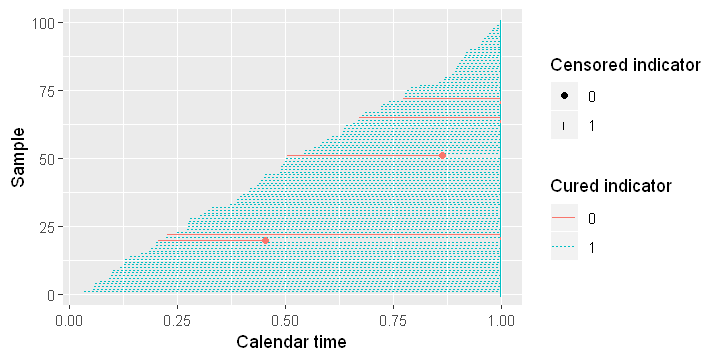

In [7]:
testdata_plot(data, calendar_time=T)

### Follow-up time

However, to understand how many players monetize we want to think of the data set in terms of the follow-up time, which looks like this:

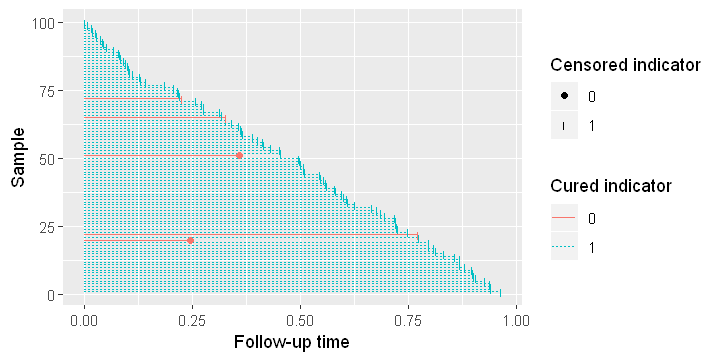

In [8]:
testdata_plot(data, calendar_time=F)

In reality, we do not know 'how many players eventually purchase' but wish to predict it. The real data set looks like this:

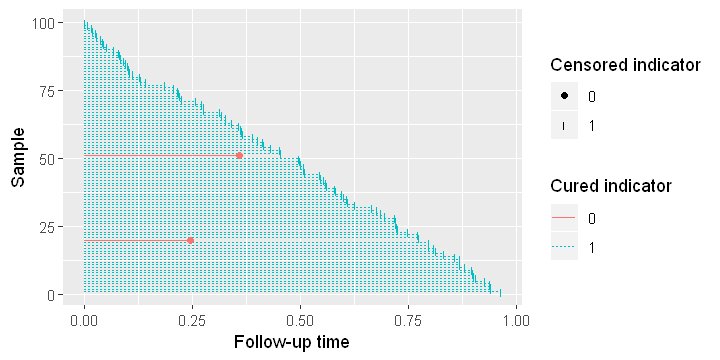

In [9]:
data$cured <- data$censored
testdata_plot(data, calendar_time=F)

> The goal is to predict how many players will eventually make a purchase from a data set like this.

## Mathematical formulation

### Survival analysis mixture cure model

Survival analysis is a field of statistics that analyzes data with event times and limited follow-ups. Our data is of this type: the event is 'a player makes a purchase' and the follow-up start when a player starts playing and ends at the data collection date. If a player makes a purchase this is the event time, and if the player has not made a purchase the  event is censored and the censoring time is the total follow-up time.

We formalize the data as samples of following random variables. The time $T = \text{min}(T^*, C)$ is either the purchase time $T^*$ or the total follow-up time $C$, depending which is smaller. The binary censoring indicator $\delta = I(C\leq T*)$ denotes whether a player made a purchase before the follow-up ended. In the paper, we assume the purchase time $T^*$ is exponentially distributed as $\text{Exp}(\lambda)$ and the censoring time $C$ is implied by the data collection time. The data sets consists of realizations $t_i = \text{min}(t_i^*, c_i)$ and $\delta_i = I(c_i\leq t_i^*)$ for every player $i$.

The survival function gives the probability that the purchase time is greater than a given time $t$:
$$ S_m(t) = P(T^* > t) = e^{-\lambda t} $$

The hazard function is the instantaneous risk of purchase among players who have not yet purchased:
$$ h_m(t) = \text{lim}_{\partial t \rightarrow 0} \frac{P(t<T^*<t+\partial t | T^* > t)}{\partial t} = \lambda$$

The probability density function of purchase times can be calculated from the survival and hazard functions:
$$ f_m(t) = h_m(t)S_m(t)$$


Standard survival analysis formulation assumes that every individual eventually has an event. This is clearly not true in free-to-play games, as most players never seem to purchase anything. The player population is therefore a mixture of two populations: purchasing players and non-purchasing players. To handle this, we use a mixture cure model. The cure indicator $\zeta$ describes whether a player purchases $\zeta = 0$ or not $\zeta = 1$. We assume it to be Bernoulli distributed $\text{Bern}(1-\pi)$ so that $P(\zeta = 0) = \pi$ and $P(\zeta = 1) = 1 - \pi$. This is a latent variable, because a player may belong to either population if they have not yet made a purchase. In a mixture cure model, the survival function is a mixture of two subpopulations where $S_m(t) = e^{-\lambda t}$ and $S_u(t) = 1$:
$$ S(t) = \pi S_m(t) + (1 - \pi) S_u(t) $$

### Fitting the model to the data set

Now, the goal is to infer the model parameters $\lambda$ and $\pi$ from a dataset $D$.

In the papers, we fit the model with maximum likelihood. The maximum likelihood estimate (MLE) is the parameters $\lambda$ and $\pi$ that maximizes the likelihood function of the data set:
$$L(D|\lambda,\pi) = \prod_{i=1}^{n}f(t|\lambda,\pi)^{1-\delta_i}S(t|\lambda,\pi)^{\delta_i}$$
Since logarithm is a stricly increasing function, in practise the log-likelihood is often used instead as it has better numercial properties:
$$\text{log}(L(D|\lambda,\pi)) = \sum_{i=1}^{n}(1-\delta_i)\text{log}(f(t|\lambda,\pi))+\delta_i\text{log}(S(t|\lambda,\pi))$$



If the purchasing players are somehow known in advance, so that $\zeta_i$ is known for every player, we call the data set **complete**. Then the solution is simple and intuitive. Denote $n_0$ as the number of purchasing players and $n_1$ the number of non purchasing players. Then the MLE of the monetization percentage is the fraction of players that purchase something and the monetization rate is the number of purchasing players divided by their total exposure time:

$$\pi=\frac{n_0}{n_0+n_1}$$

$$\lambda=\frac{n_0}{\sum_{i:\zeta_i=0} t_i} $$

The function below implements the algorithm for complete data:

In [10]:
cure <- function(data) {
  result = c(sum(data$cured == 0) / sum(data$time[data$cured == 0]), 
             sum(data$cured == 0) / length(data$cured))
  return(result)
}


If the purchasing players are not known, so that $\zeta_i$ is a latent variable, we call the data set **incomplete**. Then it is not possible to derive an explicit equation for the MLE. However, in the paper we show that it is possible to use the Expectation Maximization (EM) algorithm to derive the following iterative algorithm for a given starting values $\pi^{(0)}$ and $\lambda^{(0)}$:

$$\pi^{(k)}=\frac{1}{n}[\sum_{i:\delta_i=1}\frac{\pi^{(k-1)}e^{-\lambda^{(k-1)}t_i}}{1-\pi^{(k-1)}+\pi^{(k-1)}e^{-\lambda^{(k-1)}t_i}}] + \sum_{i:\delta_i=0}1$$

$$\lambda^{(k)}=\frac{\sum_{i:\delta_i=0}1}{\sum_{i:\delta_i=1}\frac{\pi^{(k-1)}e^{-\lambda^{(k-1)}t_i}}{1-\pi^{(k-1)}+\pi^{(k-1)}e^{-\lambda^{(k-1)}t_i}}t_i + \sum_{i:\delta_i=0}t_i}$$

The function below implements the algorithm for incomplete data:

In [11]:
# EM-algorithm for a mixture cure model
cureEM <- function(params, D){
  
  if(all(D$censored == 1)){
    return(c(lambda = NA, pi = 0.0))
  }
  
  lambda_prev <- params[1]
  pi_prev <- params[2]

  n <- length(D$time)
  time_censored <- D$time[D$censored==1]
  time_not_censored <- D$time[D$censored==0]
  
  # Precision of the result
  eps <- 10^(-9)
  continue <- TRUE
  
  while(continue){
    
    # Calculate the weights
    D$weight[D$censored == 1] <- ifelse(time_censored == Inf, 0, 
                                        pi_prev*exp(-lambda_prev*time_censored) /
                                        (1-pi_prev + pi_prev*exp(-lambda_prev*time_censored)))
    D$weight[D$censored == 0] <- 1
    
    # Calculate the new values of the parameters
    pi <- (sum(D$weight))/n
    
    lambda <- sum(D$weight[D$censored == 0])/
      (sum(ifelse(time_censored == Inf, 0, D$weight[D$censored == 1]*time_censored)) +
         sum(D$weight[D$censored == 0]*time_not_censored))
    
    # Did the algorithm converge yet? If not, update the values of the parameters
    if(sqrt((pi_prev - pi)^2 + (lambda_prev - lambda)^2) < eps){
      continue <- FALSE
    }else{
      lambda_prev <- lambda
      pi_prev <- pi
    }
  }

  return(c(lambda, pi))
}

Now there are some problematic cases when the algorithm does not work correctly. If the monetization percentage is small (0.1-10% are realistic) and the sample size is not large, it is possible that the sample does not include any monetizing players. In this case, the solution is not defined and the algorithm does not converge. Additionally, with very few monetizing players there are two solutions that are very close to each other in likelihood and the algorithm converges very slowly: 1.) a large proportion monetizes but the monetization rate is very small 2.) a small proportion monetizes and the monetization rate is reasonable. We can fix both of these problems with 'add one' or Laplace smoothing, which is sometimes used in probablistic models to deal with the zero-frequency problem. We simply add one pseudo-player that we know to be non monetizing, which in practise means that this player did not purchase and had an infinite follow-up (this is just a cool way to code asymptotic results directly ;-) ):

In [24]:
testdata_addone <- function(df) {
  one <- data.frame(max(df$sample)+1, 1, 0, NA, Inf, Inf, NA, 1)
  names(one) <- c("sample", "cured", "time_start", "time_purchase", "time_end", "followup", "time", "censored")
  df <- rbind(df, one)
  return(df)
}

Now, there is a more formal way to incorporate this to the algorithm. Bayesian inference can be used to incorporate prior knowledge about the monetization percentage. We can specify 'a prior distribution' of how we believe the monetization percentage to be distributed before we see any data, and update our belief based on the observed data. This is the Maximum a Posteriori (MAP) estimate. A natural prior for the Bernoulli distributed monetization percentage $\pi$ is the Beta distribution. In the following figure, we visualize the following prior distributions:
1. Beta(1,1): every $\pi$ is equally likely, implies no prior information and actually corresponds to the MLE.
2. Beta(1,2): smaller $\pi$ is more slightly more likely with $\pi=1.0$ not possible, implies weak prior information and actually corresponds to adding the one non-monetizing player.
3. Beta(2, 10): smaller $\pi$ around 0.00-0.20 are most likely with $\pi=0.05$ expectation, implies some prior information and corresponds to adding one monetizing and 19 non-monetizing players.

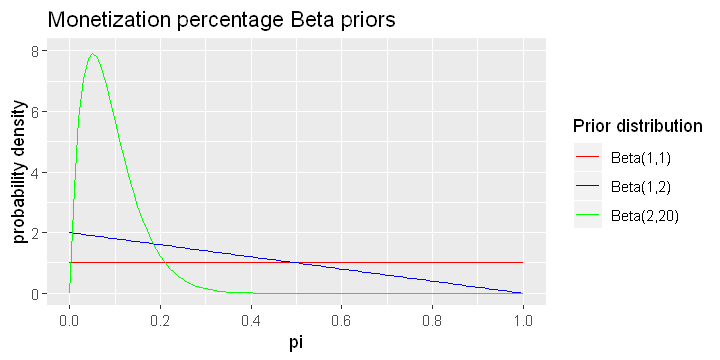

In [22]:
x <- seq(0.00, 1.00, 0.01)
fun.1 <- function(x) dbeta(x, 1, 1, ncp = 0, log = FALSE)
fun.2 <- function(x) dbeta(x, 1, 2, ncp = 0, log = FALSE)
fun.3 <- function(x) dbeta(x, 2, 20, ncp = 0, log = FALSE)

ggplot(data.frame(x=c(0.0, 1.0)), aes(x=x)) + 
  geom_path(aes(colour="red"), stat="function", fun=fun.1)+
  geom_path(aes(colour="blue"), stat="function", fun=fun.2) +
  geom_path(aes(colour="green"), stat="function", fun=fun.3) +
  scale_colour_identity("Prior distribution", guide="legend", 
                        labels = c("Beta(1,1)", "Beta(1,2)", "Beta(2,20)"), 
                        breaks = c("red", "blue", "green")) +
  scale_x_continuous(name="pi", limits=c(0, 1), breaks=seq(0,1,0.2)) +
  scale_y_continuous(name="probability density", limits=c(0, 8)) +
  ggtitle("Monetization percentage Beta priors")



This is an extension of the algorithm for incomplete data with prior knowledge:

In [12]:
# EM-algorithm for a mixture cure model with beta distribution as a prior 
cureEMprior <- function(params, D, betapriorparams = c(1,1)){
  
  if(all(D$censored == 1)){
    return(c(lambda = NA, pi = 0.0))
  }
  
  lambda_prev <- params[1]
  pi_prev <- params[2]
  
  alpha <- betapriorparams[1]
  beta <- betapriorparams[2]
  
  n <- length(D$time)
  time_censored <- D$time[D$censored==1]
  time_not_censored <- D$time[D$censored==0]
  
  # Precision of the result
  eps <- 10^(-9)
  continue <- TRUE
    
  while(continue){
    
    # Calculate the weights
    D$weight[D$censored == 1] <- ifelse(time_censored == Inf, 0, 
                                        pi_prev*exp(-lambda_prev*time_censored) /
                                          (1-pi_prev + pi_prev*exp(-lambda_prev*time_censored)))
    D$weight[D$censored == 0] <- 1
    
    # Calculate the new values of the parameters
    pi <- (sum(D$weight) + alpha-1)/(n + alpha+beta-2)
    
    lambda <- sum(D$weight[D$censored == 0])/
      (sum(ifelse(time_censored == Inf, 0, D$weight[D$censored == 1]*time_censored)) +
         sum(D$weight[D$censored == 0]*time_not_censored))
    
    # Did the algorithm converge yet? If not, update the values of the parameters
    if(sqrt((pi_prev - pi)^2 + (lambda_prev - lambda)^2) < eps){
      continue <- FALSE
    }else{
      lambda_prev <- lambda
      pi_prev <- pi
    }
  }

  return(c(lambda, pi))
}

## Examples

### Complete data

First we generate some complete data where we know the monetizing players. This corresponds to a hypothetical scenario with infinite follow-ups:

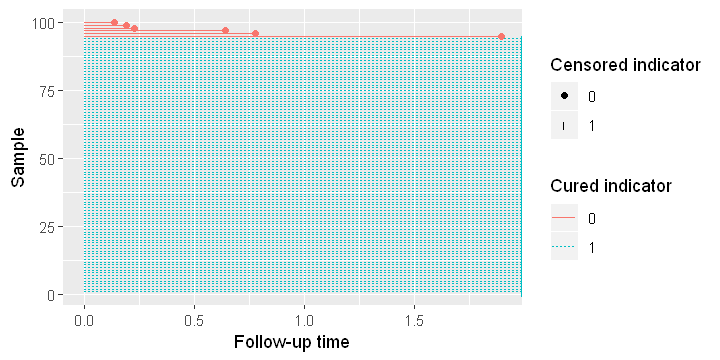

In [13]:
data <- testdata_generate(n=100)
data <- testdata_censor(data, time_end=Inf)
testdata_plot(data, calendar_time=F)

We see that 6 players monetized out of 100 and the rest were censored because they do not monetize:

In [14]:
data$weight <- 1
data$time <- ifelse(is.na(data$time), data$followup, data$time)
data <- data[,c('time', 'cured', 'censored', 'weight')]
addmargins(table(data[c('cured', 'censored')]))

,0,1,Sum
0,6,0,6
1,0,94,94
Sum,6,94,100


The straightforward calculation states that 6% of players monetize, as expected:

In [16]:
params <- cure(data)
print(params)

[1] 1.545778 0.060000


The mixture cure model returns the same result:

In [15]:
init <- c(0.5, 0.05)
params <- cureEM(init, data)
print(params)

[1] 1.545778 0.060000


### Incomplete data

Lets generate some incomplete data where we do not know the monetizing players. In this realistic setting, the method has to guess the monetizing players:

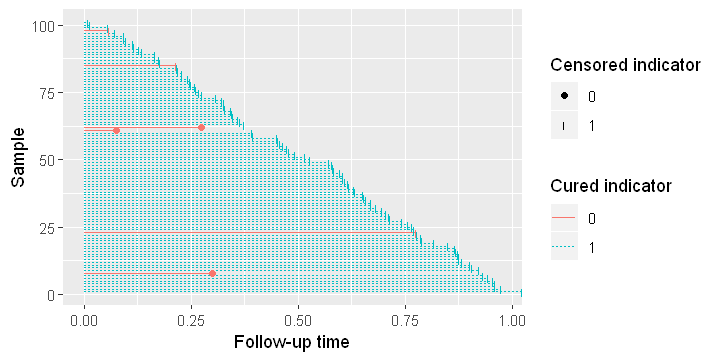

In [18]:
data <- testdata_generate(n=100, start_max=1)
data <- testdata_censor(data, time_end=1)
data <- testdata_addone(data)
testdata_plot(data, calendar_time=F)

In this setting, 3 players have monetized and 3 more will do so eventually, out of 100 (+1 add-one smoothing):

In [19]:
data$weight <- 1
data$time <- ifelse(is.na(data$time), data$followup, data$time)
data <- data[,c('time', 'cured', 'censored', 'weight')]
addmargins(table(data[c('cured', 'censored')]))

,0,1,Sum
0,3,3,6
1,0,95,95
Sum,3,98,101


The cureEM algorithm predicts that 4.5 will monetize eventually. The data was generated with 5% true monetization rate, so pretty close:

In [20]:
init <- c(0.5, 0.05)
params <- cureEM(init, data)
print(params)

[1] 2.64029258 0.04456779


### Prior information

We can add some small prior knowledge by stating that monetization percentages around 0-20% are most likely, where the prior distribution actually has a 5% expected value. The resulting estimate is slightly higher 4.7% because the prior influences it towards 5%: 

In [23]:
init <- c(0.5, 0.05)
params <- cureEMprior(init, data, betapriorparams = c(2,20))
print(params)

[1] 2.52422480 0.04651319


## Simulation experiments


In the above examples we generated a single dataset and predicted the monetization percentage. In practise, it is essential to know how the algorithm works for different types of data and different realizations (samples) of the underlying data. In the following, we therefore make a simple simulation where we vary the number of samples (100, 1000, 10 000) and limited follow-up times (20%, 40%, 60%, 80%, 100% expected to monetize) and generate a data set 100 times, saving the predictions. We use a monetization percentage of 10% and monetization rate of 1.0. There are two simulations:

1. Complete data: for comparison we illustrate the hypothetical case of complete data
2. Incomple data: we illustrate how the method works for the realistic case of incomplete data

### Complete data

This runs the simlation for complete data (quite fast):

In [60]:
# Run iterations (i) of cure (complete data) over number of samples (n) and time (t)
cure_fraction = 0.9
rate = 1.0
n_ = c(100, 1000, 10000)#n_ <- 2**seq(7,16)
t_ = qexp(c(0.2,0.4,0.6,0.8,1.0), rate=rate) #t_ <- qexp(seq(0.1,1.0,0.1), rate=rate)
rep <- 100
experiments <- list()
x <- 1
run.time <- 0
for (i in seq(rep)) {
  print(sprintf("Repetition: %d", i))
  experiment.start <- Sys.time()
  for (n in n_) {
    for (t in t_) {
      testdata1 <- testdata_generate(n=n, cure_fraction=cure_fraction, rate=rate)
      testdata1 <- testdata_censor(testdata1, time_end=Inf)
      #testdata1 <- testdata_addone(testdata1)
      data <- testdata1
      data$weight <- 1
      data$time <- ifelse(is.na(data$time), data$followup, data$time)
      params <- cure(data)
      experiment <- c(n=n, t=t, lambda=params[1], pi=params[2])
      experiments[[x]] <- experiment
      x <- x + 1
    }
  }
  experiment.end <- Sys.time()
  run.time <- run.time + (experiment.end - experiment.start)
  experiment.time <- as.double(run.time/i, unit="mins")
  print(sprintf("Estimated time remaining: %f mins", (rep - i)*experiment.time))
}
# Save results to experiments_cureEM.csv or experiments_cure.csv
experiments.df <- as.data.frame(do.call(rbind, experiments))

[1] "Repetition: 1"
[1] "Estimated time remaining: 0.027974 mins"
[1] "Repetition: 2"
[1] "Estimated time remaining: 0.030135 mins"
[1] "Repetition: 3"
[1] "Estimated time remaining: 0.027947 mins"
[1] "Repetition: 4"
[1] "Estimated time remaining: 0.032712 mins"
[1] "Repetition: 5"
[1] "Estimated time remaining: 0.030318 mins"
[1] "Repetition: 6"
[1] "Estimated time remaining: 0.028645 mins"
[1] "Repetition: 7"
[1] "Estimated time remaining: 0.027383 mins"
[1] "Repetition: 8"
[1] "Estimated time remaining: 0.026953 mins"
[1] "Repetition: 9"
[1] "Estimated time remaining: 0.026050 mins"
[1] "Repetition: 10"
[1] "Estimated time remaining: 0.025282 mins"
[1] "Repetition: 11"
[1] "Estimated time remaining: 0.024880 mins"
[1] "Repetition: 12"
[1] "Estimated time remaining: 0.024257 mins"
[1] "Repetition: 13"
[1] "Estimated time remaining: 0.023694 mins"
[1] "Repetition: 14"
[1] "Estimated time remaining: 0.023485 mins"
[1] "Repetition: 15"
[1] "Estimated time remaining: 0.022983 mins"
[1] 

We observe well-known statistical asymptotic results: the MLE approaches the true value in probability as the sample size increases. Increasing the sample size is quite helpful and reliable estimates can be obtained even with short 20% follow-ups:

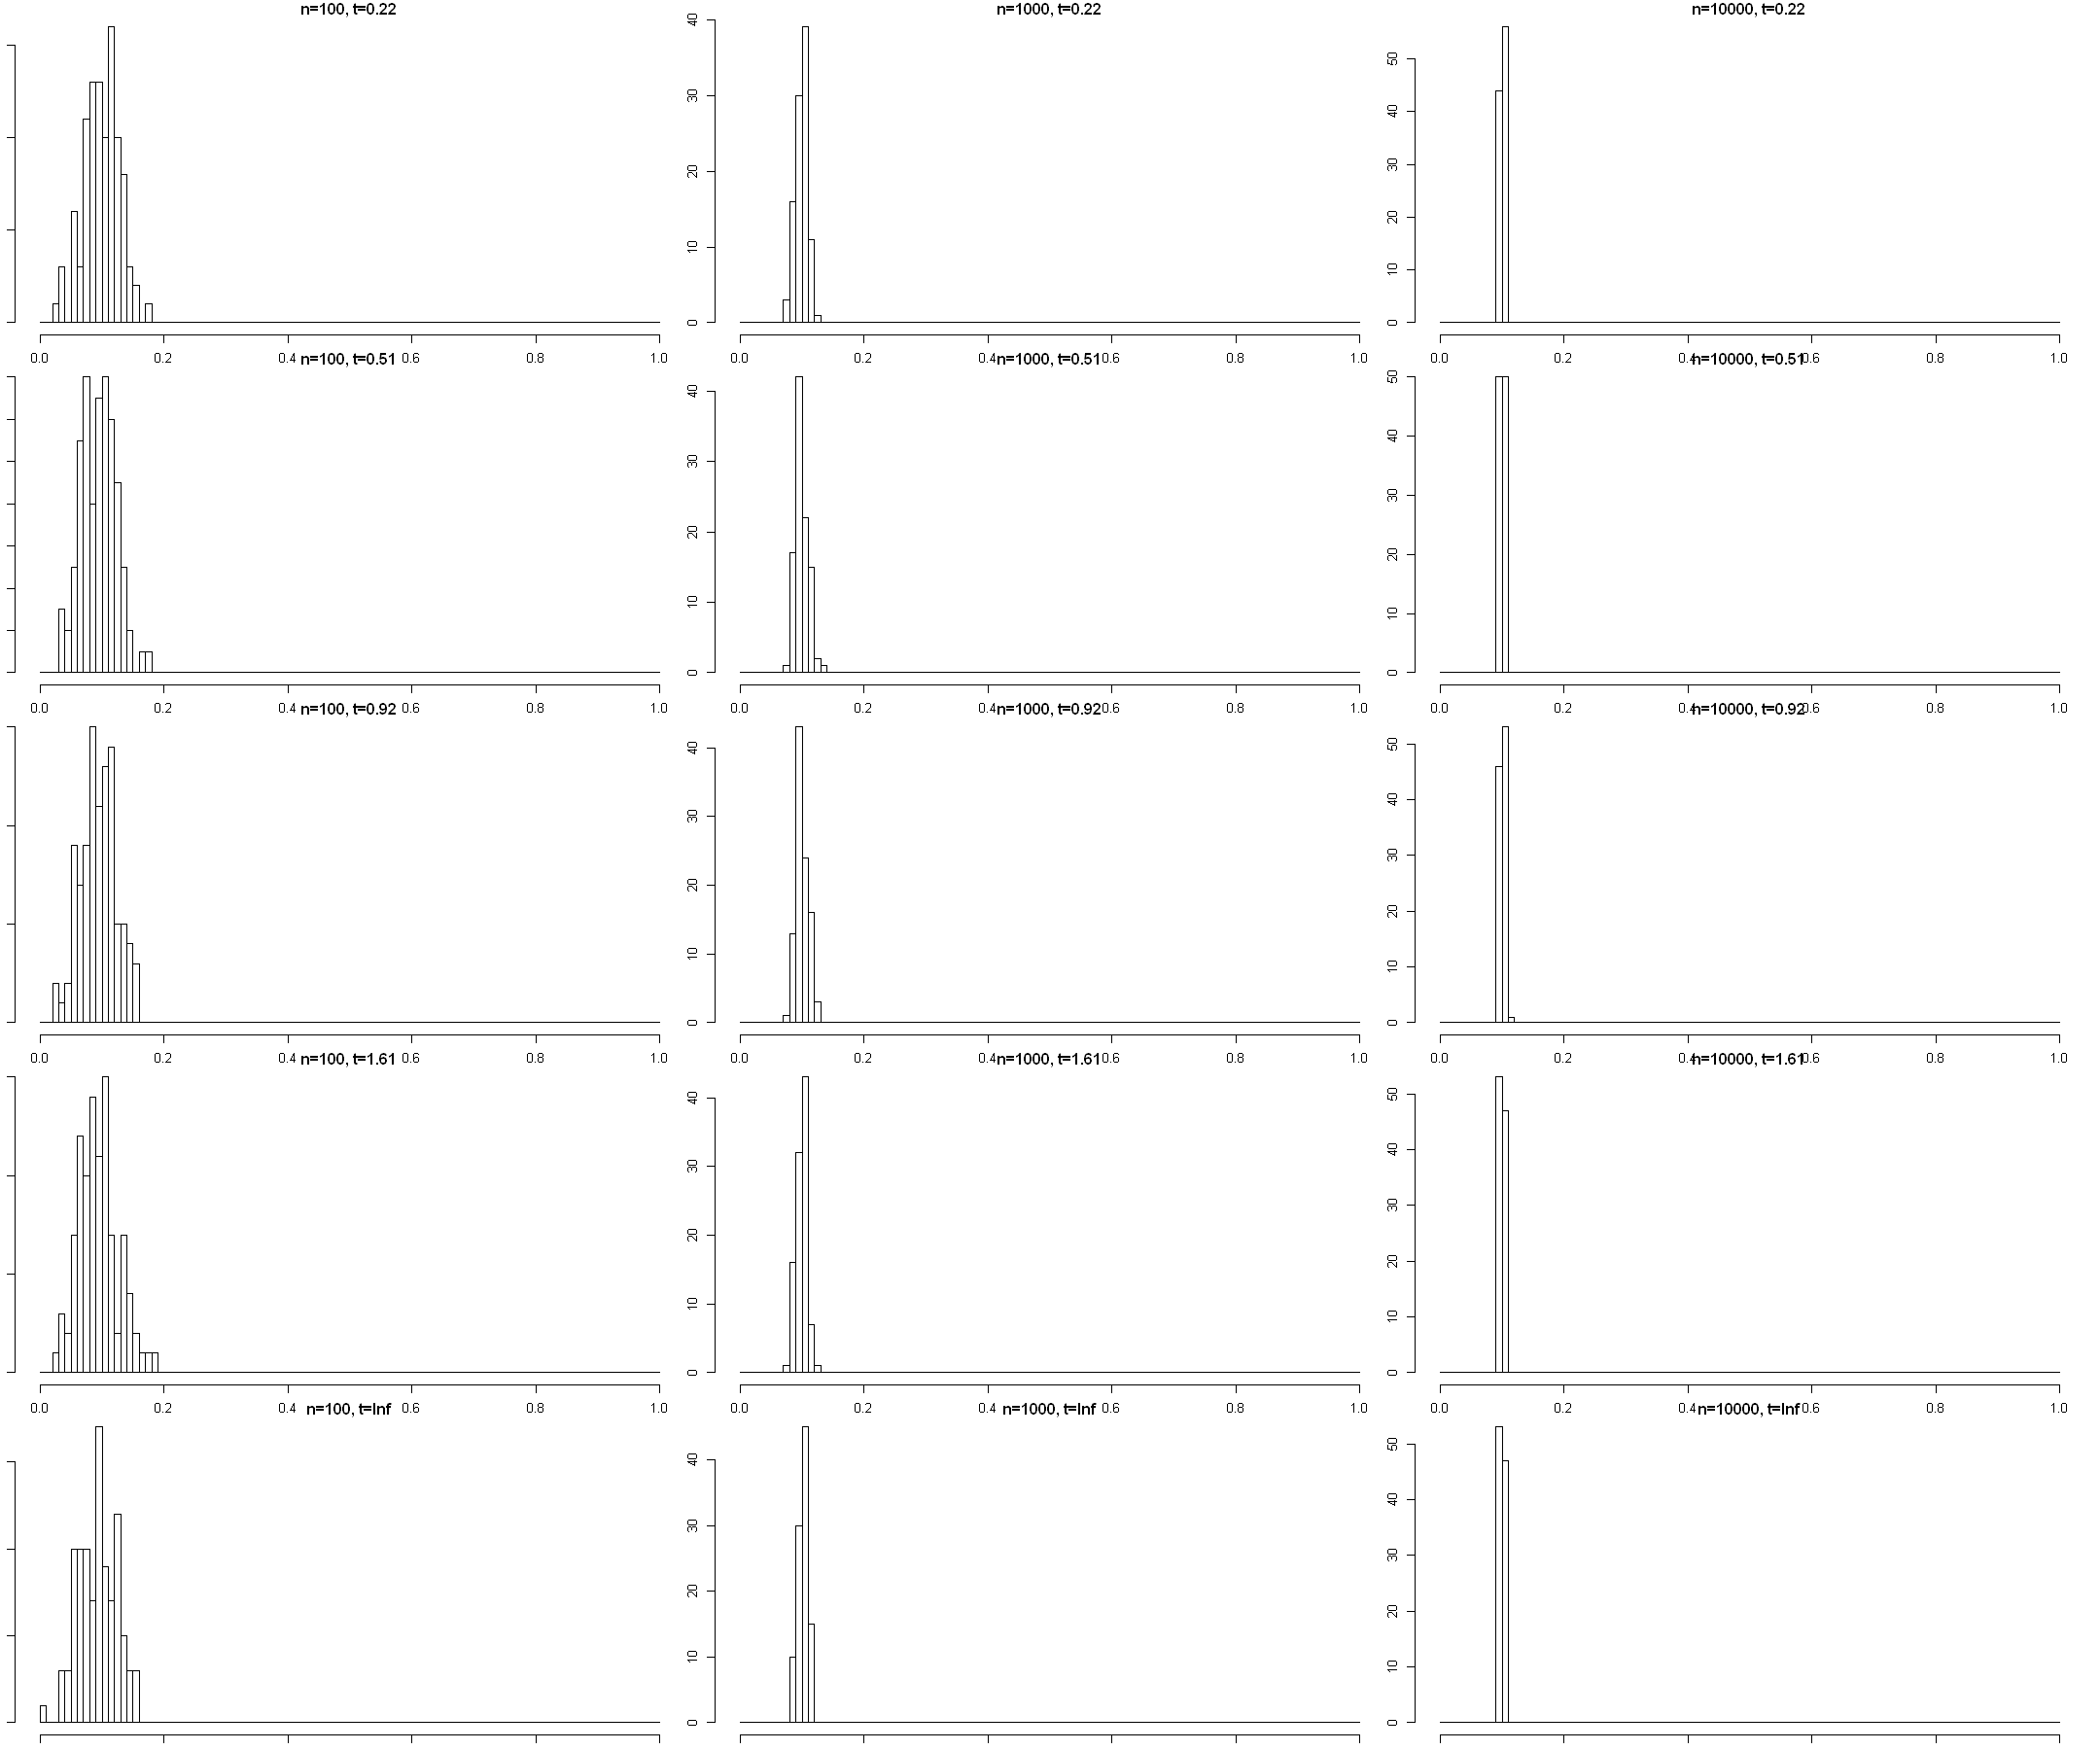

In [67]:
experiments.values <- aggregate(pi ~ n + t, experiments.df, list)

# Plot histogram or 'pi' over samples (n) x time (t) pairs
plot_values <- function (experiment) {
  title <- sprintf("n=%d, t=%.2f", experiment$n, experiment$t)
  hist(experiment$pi, breaks=seq(0.00,1.00,0.01), main=title)
}
t.total <- length(unique(experiments.values$t))
n.total <- length(unique(experiments.values$n))
options(repr.plot.width=6*n.total, repr.plot.height=3*t.total)
par(mfrow=c(t.total, n.total), mar=c(1,1,1,1))
invisible(apply(experiments.values, 1, plot_values))

As expected, the estimates are unbiased and variance is inversely proportional to the sample size:

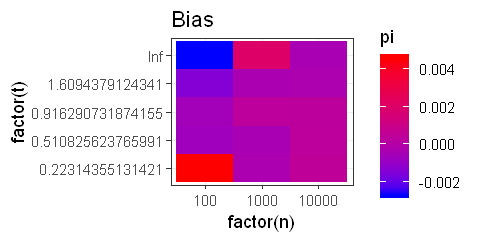

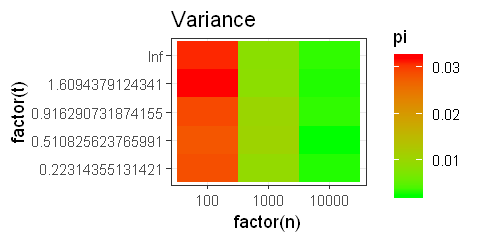

In [73]:
experiments.mean <- aggregate(pi ~ n + t, experiments.df, mean)
experiments.sd <- aggregate(pi ~ n + t, experiments.df, sd)

# Plot bias and variance over samples (n) x time (t) pairs
experiments.bias <- experiments.mean
experiments.bias$pi <- experiments.bias$pi - (1.0 - cure_fraction)

options(repr.plot.width=4, repr.plot.height=2)
ggplot(experiments.bias, aes(factor(n), factor(t), z=pi)) + geom_tile(aes(fill=pi)) + theme_bw() + 
    scale_fill_gradient(low='blue', high='red') + ggtitle('Bias')
ggplot(experiments.sd, aes(factor(n), factor(t), z=pi)) + geom_tile(aes(fill=pi)) + theme_bw() + 
    scale_fill_gradient(low='green', high='red') + ggtitle('Variance')


### Incompete data

This runs the simulation for incomplete data (takes time):

In [74]:
# Run iterations (i) of cureEM (incomplete data) or cure (complete data) over number of samples (n) and time (t)
cure_fraction = 0.9
rate = 1.0
n_ = c(100, 1000, 10000)#n_ <- 2**seq(7,16)
t_ = qexp(c(0.2,0.4,0.6,0.8,1.0), rate=rate) #t_ <- qexp(seq(0.1,1.0,0.1), rate=rate)
rep <- 100
experiments <- list()
x <- 1
run.time <- 0
for (i in seq(rep)) {
  print(sprintf("Repetition: %d", i))
  experiment.start <- Sys.time()
  for (n in n_) {
    for (t in t_) {
        testdata1 <- testdata_generate(n=n, cure_fraction=cure_fraction, rate=rate)
        testdata1 <- testdata_censor(testdata1, time_end=t)
        testdata1 <- testdata_addone(testdata1)
        data <- testdata1
        data$weight <- 1
        data$time <- ifelse(is.na(data$time), data$followup, data$time)
        params <- cureEM(c(0.5, 0.05), data)
        experiment <- c(n=n, t=t, lambda=params[1], pi=params[2])
        experiments[[x]] <- experiment
        x <- x + 1
    }
  }
  experiment.end <- Sys.time()
  run.time <- run.time + (experiment.end - experiment.start)
  experiment.time <- as.double(run.time/i, unit="mins")
  print(sprintf("Estimated time remaining: %f mins", (rep - i)*experiment.time))
}
# Save results to experiments_cureEM.csv or experiments_cure.csv
experiments.df <- as.data.frame(do.call(rbind, experiments))


[1] "Repetition: 1"
[1] "Estimated time remaining: 62.610070 mins"
[1] "Repetition: 2"
[1] "Estimated time remaining: 84.276819 mins"
[1] "Repetition: 3"
[1] "Estimated time remaining: 88.706514 mins"
[1] "Repetition: 4"
[1] "Estimated time remaining: 77.553906 mins"
[1] "Repetition: 5"
[1] "Estimated time remaining: 69.302795 mins"
[1] "Repetition: 6"
[1] "Estimated time remaining: 62.630069 mins"
[1] "Repetition: 7"
[1] "Estimated time remaining: 56.316168 mins"
[1] "Repetition: 8"
[1] "Estimated time remaining: 56.735370 mins"
[1] "Repetition: 9"
[1] "Estimated time remaining: 52.362124 mins"
[1] "Repetition: 10"
[1] "Estimated time remaining: 54.079055 mins"
[1] "Repetition: 11"
[1] "Estimated time remaining: 51.420353 mins"
[1] "Repetition: 12"
[1] "Estimated time remaining: 53.585610 mins"
[1] "Repetition: 13"
[1] "Estimated time remaining: 49.896603 mins"
[1] "Repetition: 14"
[1] "Estimated time remaining: 51.106443 mins"
[1] "Repetition: 15"
[1] "Estimated time remaining: 47.79

The well-known statistical asymptotic results should apply here too. However, the MLE approaches the true value in probability very slowly as the sample size increases. Increasing the sample size is not very helpful in practise and a large variance in the estimates decreases slowly unless the follow-up time is increased. This is a quite surprising result, which demonstrates that asymptotic guarantees may not always translate to practical guarantees:

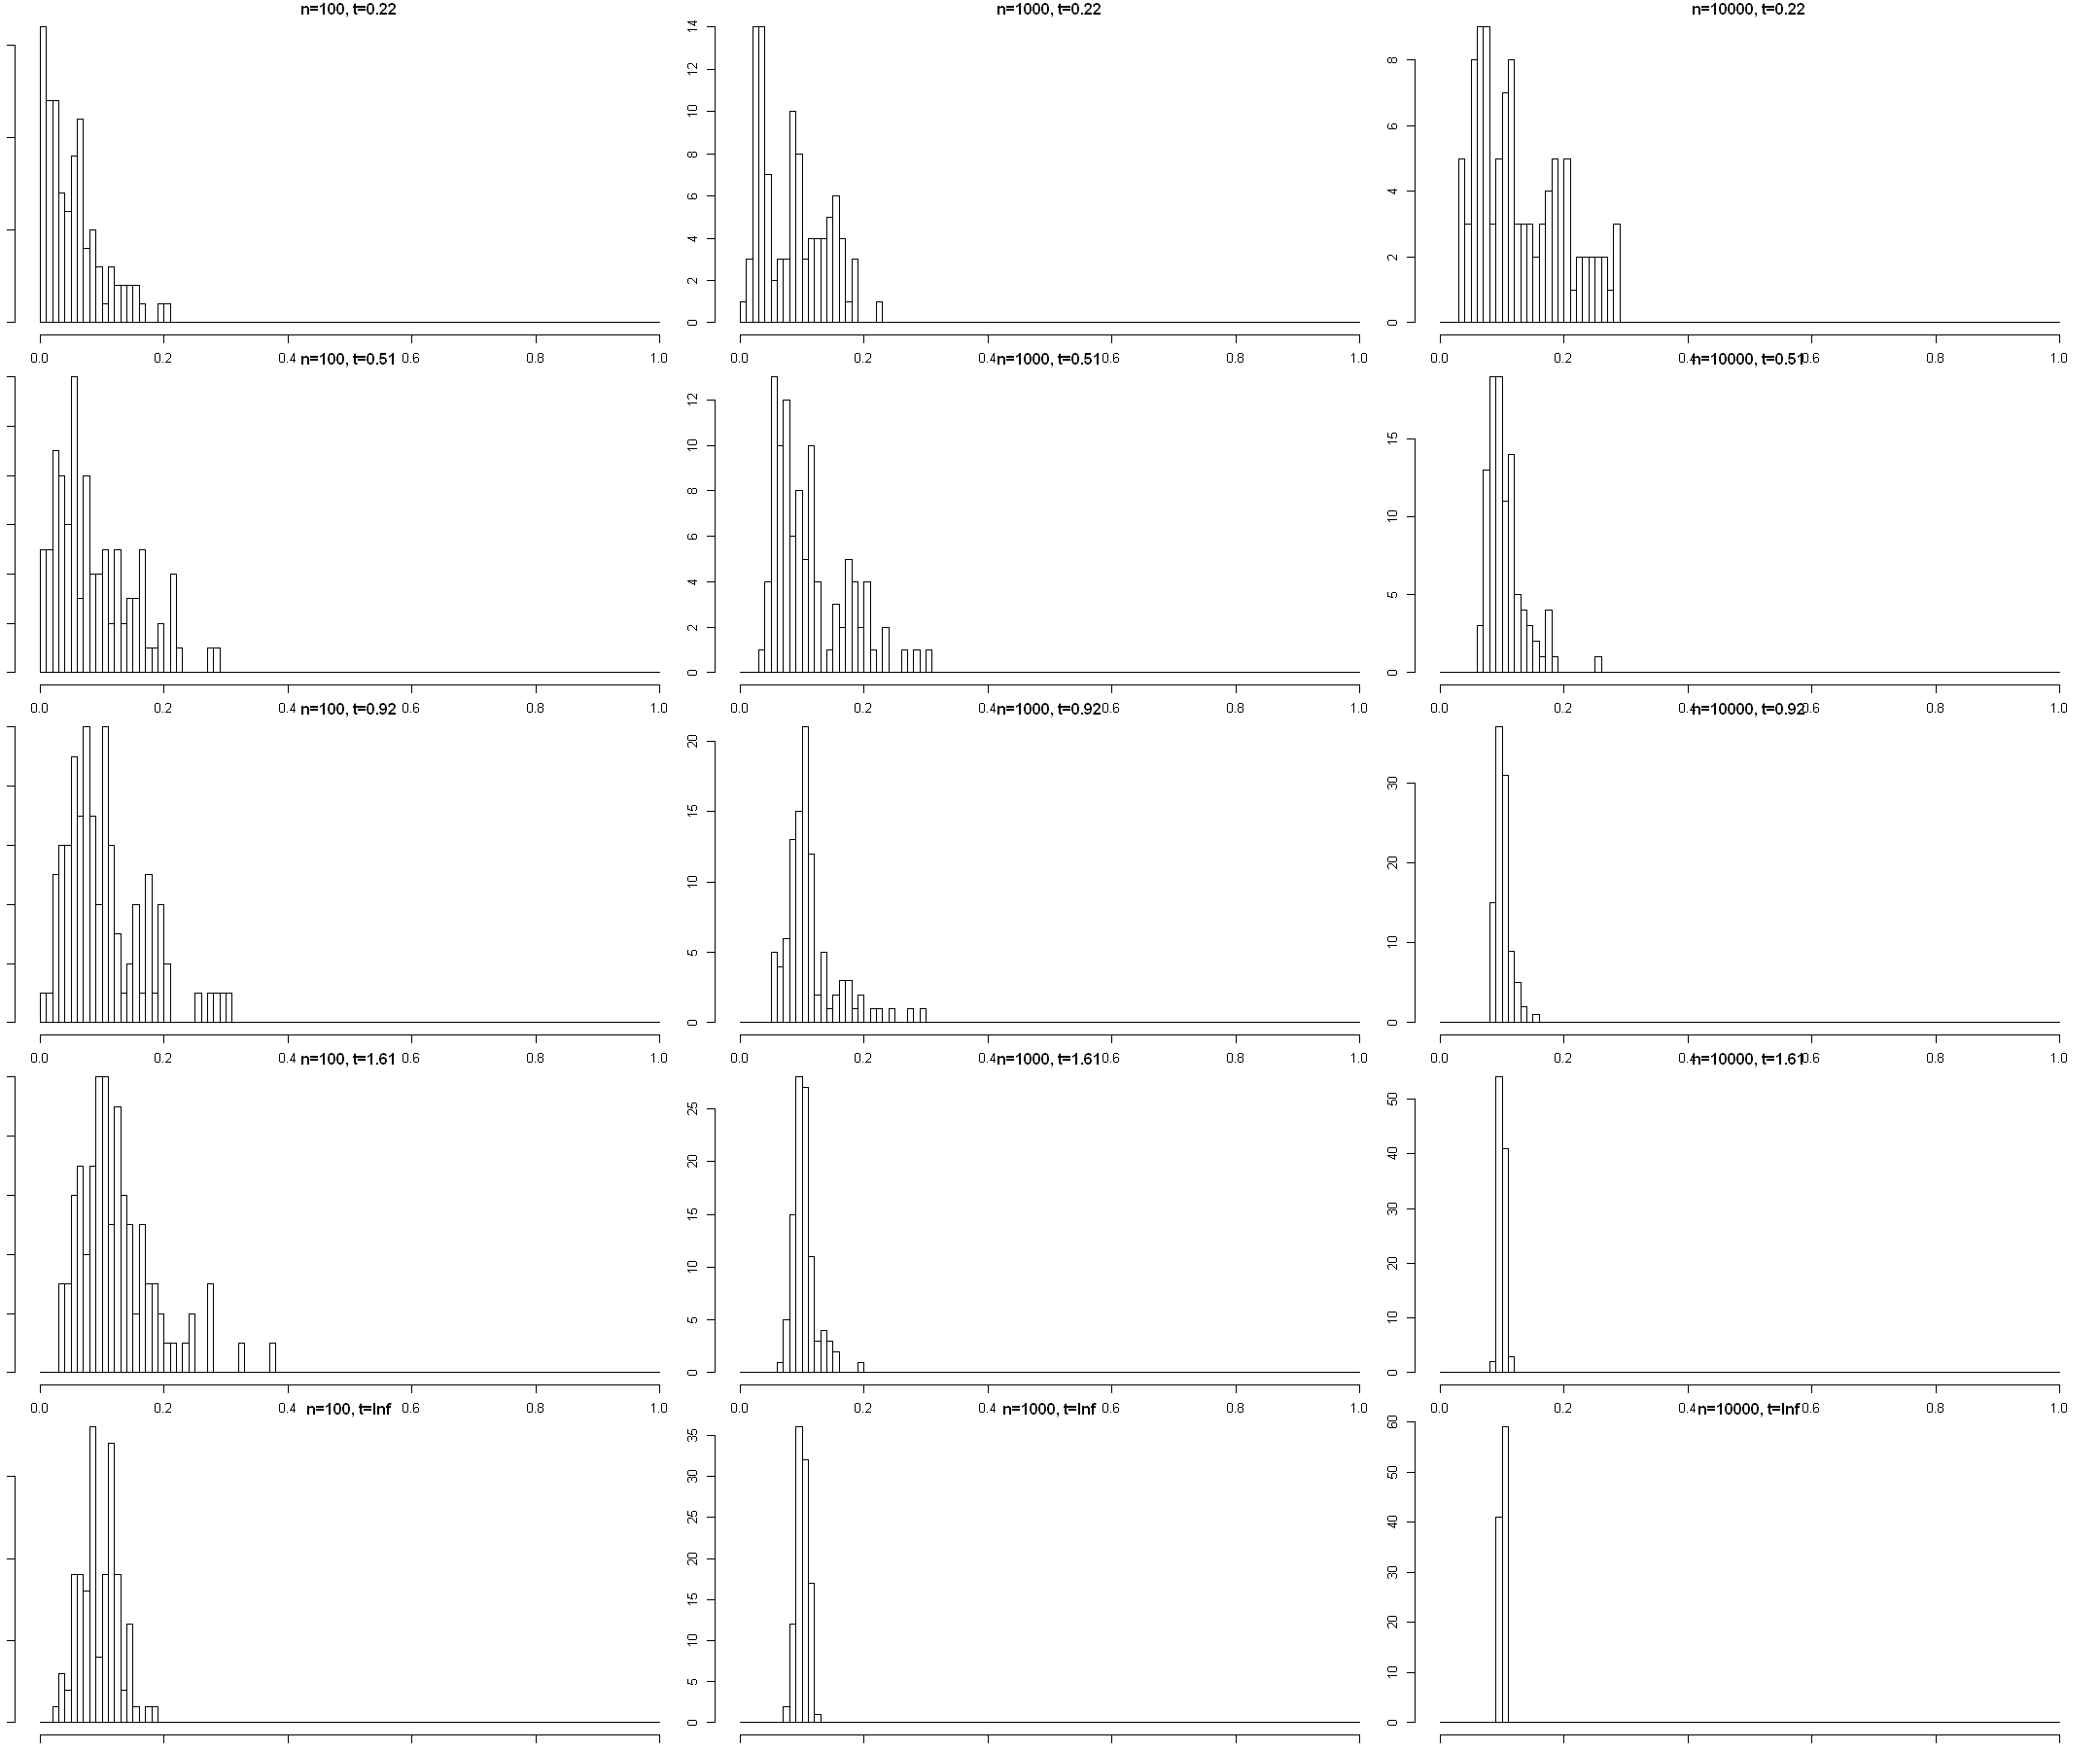

In [75]:
experiments.values <- aggregate(pi ~ n + t, experiments.df, list)

# Plot histogram or 'pi' over samples (n) x time (t) pairs
plot_values <- function (experiment) {
  title <- sprintf("n=%d, t=%.2f", experiment$n, experiment$t)
  hist(experiment$pi, breaks=seq(0.00,1.00,0.01), main=title)
}
t.total <- length(unique(experiments.values$t))
n.total <- length(unique(experiments.values$n))
options(repr.plot.width=6*n.total, repr.plot.height=3*t.total)
par(mfrow=c(t.total, n.total), mar=c(1,1,1,1))
invisible(apply(experiments.values, 1, plot_values))

The method is somewhat biased, it tends to underestimate the monetization percentage for smaller sample sizes and follow-up times. Both larger sample sizes and larger follow-up times are required to decrease the variance:

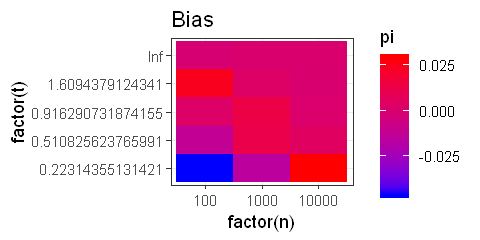

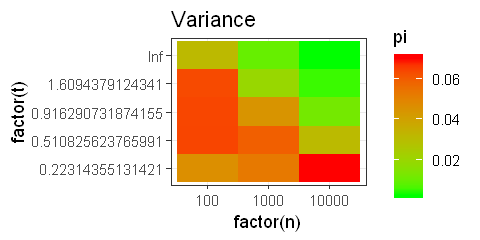

In [76]:
experiments.mean <- aggregate(pi ~ n + t, experiments.df, mean)
experiments.sd <- aggregate(pi ~ n + t, experiments.df, sd)

# Plot bias and variance over samples (n) x time (t) pairs
experiments.bias <- experiments.mean
experiments.bias$pi <- experiments.bias$pi - (1.0 - cure_fraction)

options(repr.plot.width=4, repr.plot.height=2)
ggplot(experiments.bias, aes(factor(n), factor(t), z=pi)) + geom_tile(aes(fill=pi)) + theme_bw() + 
    scale_fill_gradient(low='blue', high='red') + ggtitle('Bias')
ggplot(experiments.sd, aes(factor(n), factor(t), z=pi)) + geom_tile(aes(fill=pi)) + theme_bw() + 
    scale_fill_gradient(low='green', high='red') + ggtitle('Variance')

## The Banana and a problem with parametric statistics

In the final example, we illustrate some funky facts about how parametric statistics is not as reliable as often though. In our application, the problem is that asymptotic guarantees based on statistical theory cannot be applied because the convergence towards the asymptotic results is extremely slow in practise. Assuming asymptotic results is contradicted by two facts:
1. The parameter's distribution should be multivariate normal. However, the likelihood surface is not an ellipsoid but an 'extremely streched Banana'
2. The parameter's distribution should tend to zero bias and variance. However, in practise this happens extremely slowly as a function of sample size.

First, we present a version of the model which saves the results between iterations:

In [77]:


# EM-algorithm for a mixture cure model with beta distribution as a prior for pi
# betapriorparams is a vector containing two parameters for the beta distribution
cureEMprior <- function(params, D, betapriorparams = c(1,1)){
  
  if(all(D$time == Inf) | all(D$censored == 1)){
    return(c(NA, 0))
  }
  
  lambda_prev <- params[1]
  pi_prev <- params[2]
  
  alpha <- betapriorparams[1]
  beta <- betapriorparams[2]
  
  n <- length(D$time)
  time_censored <- D$time[D$censored==1]
  time_not_censored <- D$time[D$censored==0]
  
  # Everyone who purchased again, did it during the same day as the first purchase
  if(all(time_not_censored == 0)){
    return(c(NA, mean(1-D$censored)))
  }
  
  # Precision of the result
  eps <- 10^(-9)
  continue <- TRUE
  
  estimates <- data.frame(lambda = lambda_prev, pi = pi_prev)
  
  while(continue){
    
    # Calculate the weights
    D$weight[D$censored == 1] <- ifelse(time_censored == Inf, 0, 
                                        pi_prev*exp(-lambda_prev*time_censored) /
                                          (1-pi_prev + pi_prev*exp(-lambda_prev*time_censored)))
    D$weight[D$censored == 0] <- 1
    
    # Calculate the new values of the parameters
    pi <- (sum(D$weight) + alpha-1)/(n + alpha+beta-2)
    
    lambda <- sum(D$weight[D$censored == 0])/
      (sum(ifelse(time_censored == Inf, 0, D$weight[D$censored == 1]*time_censored)) +
         sum(D$weight[D$censored == 0]*time_not_censored))
    
    # Did the algorithm converge yet? If not, update the values of the parameters
    if(sqrt((pi_prev - pi)^2 + (lambda_prev - lambda)^2) < eps){
      continue <- FALSE
    }else{
      lambda_prev <- lambda
      pi_prev <- pi
    }
    estimates <- rbind(estimates, c(lambda_prev, pi_prev))
  }

  # result <- c(lambda, pi)
  return(estimates)
}

In [78]:
# EM-algorithm for a mixture cure model with beta distribution as a prior 
cureEMprior <- function(params, D, betapriorparams = c(1,1)){
  
  if(all(D$censored == 1)){
    return(c(lambda = NA, pi = 0.0))
  }
  
  lambda_prev <- params[1]
  pi_prev <- params[2]
  
  alpha <- betapriorparams[1]
  beta <- betapriorparams[2]
  
  n <- length(D$time)
  time_censored <- D$time[D$censored==1]
  time_not_censored <- D$time[D$censored==0]
  
  # Precision of the result
  eps <- 10^(-9)
  continue <- TRUE

  estimates <- data.frame(lambda = lambda_prev, pi = pi_prev)
  
  while(continue){
    
    # Calculate the weights
    D$weight[D$censored == 1] <- ifelse(time_censored == Inf, 0, 
                                        pi_prev*exp(-lambda_prev*time_censored) /
                                          (1-pi_prev + pi_prev*exp(-lambda_prev*time_censored)))
    D$weight[D$censored == 0] <- 1
    
    # Calculate the new values of the parameters
    pi <- (sum(D$weight) + alpha-1)/(n + alpha+beta-2)
    
    lambda <- sum(D$weight[D$censored == 0])/
      (sum(ifelse(time_censored == Inf, 0, D$weight[D$censored == 1]*time_censored)) +
         sum(D$weight[D$censored == 0]*time_not_censored))
    
    # Did the algorithm converge yet? If not, update the values of the parameters
    if(sqrt((pi_prev - pi)^2 + (lambda_prev - lambda)^2) < eps){
      continue <- FALSE
    }else{
      lambda_prev <- lambda
      pi_prev <- pi
    }
    estimates <- rbind(estimates, c(lambda_prev, pi_prev))
  }

  return(estimates)
}


Lets generate some data:

In [96]:
#set.seed(9863)
testdata2 <- testdata_generate(n=100, start_max=1)
testdata2 <- testdata_censor(testdata2, time_end=1)
testdata2$weight <- 1
testdata2$time <- ifelse(is.na(testdata2$time), testdata2$followup, testdata2$time)

In [97]:
addmargins(table(testdata2[c('cured', 'censored')]))

,0,1,Sum
0,2,3,5
1,0,95,95
Sum,2,98,100


And fit the model with / without a prior:

In [103]:
initial_guess <- c(0.5,0.5)
estimates_all_iterations <- cureEMprior(initial_guess, testdata2)
estimates_all_iterations_prior <- cureEMprior(initial_guess, testdata2, betapriorparams = c(2,20))

The MLE without pseudo-observations or prior information thinks that 100% monetize with 0.04 monetization rate:

In [106]:
tail(estimates_all_iterations, 1)

,lambda,pi
83648,0.03960415,0.9999921


The MAP with a Beta(2,20) prior with little additional information thinks that 6.4% monetize with 0.64 monetization rates:

In [107]:
tail(estimates_all_iterations_prior, 1)

,lambda,pi
113,0.6406448,0.06418861


The following code calculates the likelihood of different combinations of $\lambda, \pi$:

In [99]:
data <- testdata2
loglikelihood_testi <- function(lambda, pi){
    delta <- data$censored
  t <- data$time
  sum((1-delta)*(log(pi) + log(lambda) -lambda*t) + delta*(log(1-pi + pi*exp(-lambda*t))))
}

# Different values for parameters
piit <- seq(0.00001,0.99999,length.out = 100)
lambdat <- seq(0.00001,3.5,length.out = 350)
params <- expand.grid(lambda = lambdat, pi = piit)

# Likelihood function values with given parameters
ll <- cbind(params, likelihood = apply(params, 1, function(i){loglikelihood_testi(i[1], i[2])}))


We plot the likelihood surface and see how the models arrive at what they think are the most likely values:

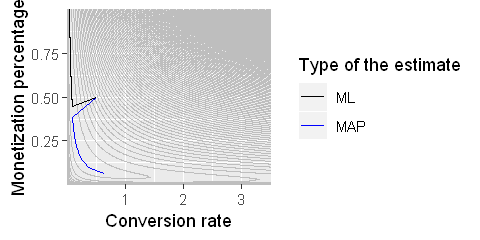

In [105]:
ggplot() + 
  geom_contour(data = ll, aes(x = lambda, y = pi, z = likelihood), colour = "grey", binwidth = 1, size = 0.2) + 
  geom_path(data = estimates_all_iterations, aes(x = lambda, y = pi, col = "1"), size = 0.3) +
  geom_path(data = estimates_all_iterations_prior, aes(x = lambda, y = pi, col = "2"), size = 0.3) +
  scale_colour_manual(breaks = c("1","2"), labels = c("ML", "MAP"), values = c("black", "blue")) +
  scale_fill_gradient2(low = "#00BFC4", mid = "white", high = "#F8766D", midpoint = -50) + 
  labs(x = "Conversion rate", y = "Monetization percentage", fill = "Log-likelihood", col = "Type of the estimate") + 
  coord_fixed(ratio = 3, expand = FALSE)

From the data likelihood, it can be seen that many values are equally likely between two extremes ('The Banana'):
1. 100% monetization percentage with 0.04 monetization rate
2. 5% monetization percentage with 1.00 monetization rate

This is quite surprising. The incorporation of prior information is essential, and even weak priors make the method produce useful results. However, these estimates vary a lot depending on the data set we get, so the method is not as robust as one might hope. This is not a problem with the method per se, but just a problem with the universe that implies a surprising fact: there are many equally likely explanations for a given data set.